In [41]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image as display_image
from okiya import draw_tiles, bin_interpretation, split_list_n, unzip, turn_number
import random

In [2]:
player = 0 # Red player
#player = 1 # Black player

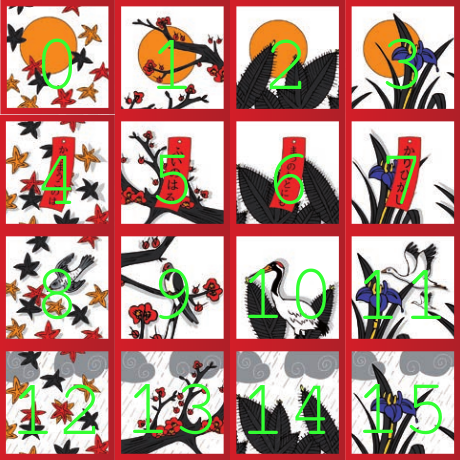

In [3]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])
img_path = draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image(img_path)

In [4]:
"""// Связи тайлов
unsigned char relations[16][6] = {
{ 1,  2,  3,  4,  8, 12}, 
{ 0,  2,  3,  5,  9, 13}, 
{ 0,  1,  3,  6, 10, 14}, 
{ 0,  1,  2,  7, 11, 15}, 
{ 0,  5,  6,  7,  8, 12}, 
{ 1,  4,  6,  7,  9, 13}, 
{ 2,  4,  5,  7, 10, 14}, 
{ 3,  4,  5,  6, 11, 15}, 
{ 0,  4,  9, 10, 11, 12}, 
{ 1,  5,  8, 10, 11, 13}, 
{ 2,  6,  8,  9, 11, 14}, 
{ 3,  7,  8,  9, 10, 15}, 
{ 0,  4,  8, 13, 14, 15}, 
{ 1,  5,  9, 12, 14, 15}, 
{ 2,  6, 10, 12, 13, 15}, 
{ 3,  7, 11, 12, 13, 14}
};"""

'// Связи тайлов\nunsigned char relations[16][6] = {\n{ 1,  2,  3,  4,  8, 12}, \n{ 0,  2,  3,  5,  9, 13}, \n{ 0,  1,  3,  6, 10, 14}, \n{ 0,  1,  2,  7, 11, 15}, \n{ 0,  5,  6,  7,  8, 12}, \n{ 1,  4,  6,  7,  9, 13}, \n{ 2,  4,  5,  7, 10, 14}, \n{ 3,  4,  5,  6, 11, 15}, \n{ 0,  4,  9, 10, 11, 12}, \n{ 1,  5,  8, 10, 11, 13}, \n{ 2,  6,  8,  9, 11, 14}, \n{ 3,  7,  8,  9, 10, 15}, \n{ 0,  4,  8, 13, 14, 15}, \n{ 1,  5,  9, 12, 14, 15}, \n{ 2,  6, 10, 12, 13, 15}, \n{ 3,  7, 11, 12, 13, 14}\n};'

In [5]:
init_tiles = np.array([
    [8,1,3,15],
    [9,10,12,2],
    [14,6,5,0],
    [11,4,7,13]
])
img_path = draw_tiles(init_tiles, draw_numbers = False, hi_res = False)
display_image(img_path)

# prepare for gpu
init_tiles_array = []
for row in init_tiles:
    init_tiles_array = np.concatenate((init_tiles_array, row), axis=0)
init_tiles_gpu = gpuarray.to_gpu(init_tiles_array.astype(np.int32))

In [6]:
len(bin_interpretation(2147483647))

31

В карте 1080-ti, MAX_GRID_DIM_X = 2 147 483 647, что позволяет обрабатывать за один такт 2 млрд комбинаций.  
Упаковать их можно в 31 бите.  
План действий:  
1. Вычисляем общее количество возможных победных комбинаций на последнем ходе: 2145. Это 12 бит.  
2. Задаем изначальное расположение тайлов на поле  
3. Все комбинации маски поля это 16 единиц, или 16 бит.  
4. Для каждого хода, передаем в ядро:  
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков.
- Входной вектор смещений побед: 2145  
- Выходной вектор: Пакет побед и комбинаций маски  
Каждый ход ядро опускается до текущего хода.  
Потоков не хватит для охвата всех вариантов первых ходов. Но это и не требуется. Ядро вызывается со смещением в поле вариантов. Исследуется только указанное окно. Поиск производится в различных окнах до тех пор, пока не будет найдено хотя бы одно победное решение. Случайное решение предлагается игроку, затем ждем хода противника и последовательность повторяется. 

# Вычислим смещения победных комбинаций

In [7]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__device__ unsigned int ones_counter(unsigned int i)
{
    unsigned int ones = 0;
    unsigned int a = 1;
    for(int b=0;b<16;b++)
    {
        if (a&i) ones++;
        a = a*2;
    }
    return(ones);
}

__device__ unsigned int convert_binary(unsigned int a, unsigned int l)
{
    unsigned int b = ~a;
    unsigned int c = b>>l;
    unsigned int d = c<<l;
    return(b-d);
}

__global__ void get_win_bias(int player, float *out_vec)
{
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    // Убедимся, что число единиц и нулей в комбинации соответствует ходу
    if (ones_counter(i)==8)
    {    
        //Перевернем комбинацию если шаблон тестирования отрицателен для игрока
        unsigned int win_tester;
        if (player) win_tester = i;
        else win_tester = convert_binary(i,16);

        // Убедимся что для выбранного игрока комбинация победна и не победна для противника
        if (win_combination(win_tester) && !win_combination(convert_binary(win_tester,16))) out_vec[i] = 1;
    }
}
""")

In [8]:
combination_check_gpu = ker.get_function("get_win_bias")

combinations = np.zeros(256*256).astype(np.float32)
#turn_id_gpu = np.int32(15)

combinations_gpu_out = gpuarray.to_gpu(combinations)


combination_check_gpu(    
    np.int32(player),
    #turn_id_gpu,
    #init_tiles_gpu,
    combinations_gpu_out,
    block=(256,1,1),
    grid=(256,1,1)
)

In [9]:
out_combinations = combinations_gpu_out.get()
win_combinations = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations))

Количество победных комбинаций: 2145


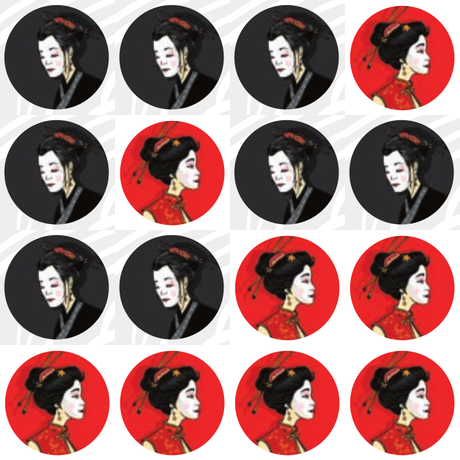

In [10]:
i = 2144# get a 100-th combination, for example
i_bin = bin_interpretation(win_combinations[i], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# Выбор хода

Итак, для любого хода нам потребуется хранить:  
- Маску: 16 бит  
- Ссылки на смещения побед: 12 бит  
Всего 27 бит

In [11]:
#MAX_GRID_DIM_X: 2147483647
bit_27 = int(''.join(['1' for i in range(16+12)]),2)
print('27 бит в десятичном представлении:', bit_27)

27 бит в десятичном представлении: 268435455


In [12]:
grid_size = np.ceil(bit_27/1024).astype(int)
print('размер сетки:', grid_size)

размер сетки: 262144


1. В это ядро передается:
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков  
- Входной вектор смещений побед: 2145 (константа)  
- Выходной вектор: Пакет победных комбинаций маски  
  
2. Из пакета комбинаций маски выбирается случайная и предлагается игроку  
3. Наш игрок Делает ход  
4. Противник делает ход  
5. Переход к п.1

In [46]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__device__ unsigned int ones_counter(unsigned int i)
{
    unsigned int ones = 0;
    unsigned int a = 1;
    for(int b=0;b<16;b++)
    {
        if (a&i) ones++;
        a = a*2;
    }
    return(ones);
}

__device__ unsigned int convert_binary(unsigned int a, unsigned int l)
{
    unsigned int b = ~a;
    unsigned int c = b>>l;
    unsigned int d = c<<l;
    return(b-d);
}

__device__ unsigned int relation_counter(int *init_tiles, unsigned int mask)
{
    // Связи тайлов
    unsigned char relations[16][6] = {
    { 1,  2,  3,  4,  8, 12}, 
    { 0,  2,  3,  5,  9, 13}, 
    { 0,  1,  3,  6, 10, 14}, 
    { 0,  1,  2,  7, 11, 15}, 
    { 0,  5,  6,  7,  8, 12}, 
    { 1,  4,  6,  7,  9, 13}, 
    { 2,  4,  5,  7, 10, 14}, 
    { 3,  4,  5,  6, 11, 15}, 
    { 0,  4,  9, 10, 11, 12}, 
    { 1,  5,  8, 10, 11, 13}, 
    { 2,  6,  8,  9, 11, 14}, 
    { 3,  7,  8,  9, 10, 15}, 
    { 0,  4,  8, 13, 14, 15}, 
    { 1,  5,  9, 12, 14, 15}, 
    { 2,  6, 10, 12, 13, 15}, 
    { 3,  7, 11, 12, 13, 14}
    };
    unsigned int relations_count = 0;
    int counter,current_closed_tile,i,j,k;
    unsigned int tiles_opened[16];
    unsigned int tiles_opened_count=0;
    unsigned int tiles_closed[16];
    unsigned int tiles_closed_count=0;
    
    // Пройдем по всем тайлам игры, определим список открытых и закрытых тайлов
    for (i=0;i<16;i++)
    {
        if(mask>>i&1)
        {   
            tiles_opened[tiles_opened_count]=init_tiles[i];
            tiles_opened_count++;            
        }
        else
        {            
            tiles_closed[tiles_closed_count]=init_tiles[i];
            tiles_closed_count++;
        }
    }
    
    // Пройдем по закрытым тайлам. Все могли быть предыдущим ходом    
    for (i=0;i<tiles_closed_count;i++)
    {                
        current_closed_tile = tiles_closed[i];
        // Пройдем по всем возможным связям текущего тайла
        for (j=0;j<6;j++)
        {            
            counter = 1;
            // Убедимся, что данная связь не входит в открытые тайлы
            for(k=0;k<tiles_opened_count;k++) if(relations[current_closed_tile][j]==tiles_opened[k]) counter = 0;
            relations_count += counter;
        }                    
    }    
    return(relations_count);
}

__global__ void turn(
    int player, 
    int turn_id, 
    int *init_tiles, 
    int *win_bias, 
    float *out_vec, 
    unsigned int *source_tiles
    )
{        
    // Количество фишек игрока на каждом ходу игры
    unsigned char turn_player_0_count[16] = {1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8};
    unsigned char turn_player_1_count[16] = {0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8};
    unsigned char turn_player_count[16];
    int k;
    if (player) for(k=0;k<16;k++) turn_player_count[k] = turn_player_1_count[k];
    else for(k=0;k<16;k++) turn_player_count[k] = turn_player_0_count[k];
    
    // Количество фишек первого игрока на каждом ходу игры
    //unsigned char turn_player_b_count[16] = {0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8};
    
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов игры
    unsigned int comb = i>>16&4095; // bias_12: >100001100001< mask_16: [1111111111111111]
    unsigned int mask = i&65535; // bias_12: [100001100001] mask_16: >1111111111111111<
    unsigned char tail_count = 15-turn_id;
    
    if (comb<2145) //2145 - game constant of win combinations count
    {        
        comb = win_bias[comb]; //Текущая комбинация, безусловно одна из победных                        
        
        // Убедимся, что число тайлов в маске соответствует ходу
        if (ones_counter(mask)==tail_count)
        {
            // Проверим, победна ли комбинация выбранного игрока среди возможных
            unsigned int win_tester;
            if (player==1) win_tester = comb;
            else win_tester = convert_binary(comb,16);
            
            //Приготовим оппонента для исключения его побед
            unsigned int opponent = convert_binary(win_tester,16);
            
            // Погасим фишки игрока и оппонента тайлами маски
            win_tester = win_tester&convert_binary(mask,16);
            opponent = opponent&convert_binary(mask,16);
            
            // Убедимся, что число единиц и нулей в комбинации соответствует ходу
            if (ones_counter(win_tester)==turn_player_count[turn_id])
            {
                // проверка на победность комбинации и поражение противника
                if (win_combination(win_tester) && !win_combination(opponent)) 
                {
                    out_vec[i] = 1;
                    // Считаем количество ходов, способных привести к данной комбинации
                    source_tiles[i] = relation_counter(init_tiles, mask);
                }
                // ToDo: 
                // Тут можно добавить долю для ничьей, для ориентира в случае отсутствии побед
                // Прототип:
                /*else if (!win_combination(opponent)) 
                {
                    out_vec[i] = 1;
                    // Считаем количество ходов, способных привести к данной комбинации
                    source_tiles[i] = relation_counter(init_tiles, mask)/2;
                }*/
            }
        }
    }
}
""")

# turn

Суммируем количество входов в каждую комбинацию по всем ходам

In [15]:
def combinations_of_turn(player, turn_id):
    turn_gpu = ker.get_function("turn")
    cores_count = 1024*262144 # 12+16 bytes
    combinations = np.zeros(cores_count).astype(np.float32)
    turn_id_gpu = np.int32(turn_id)

    win_combinations_gpu = gpuarray.to_gpu(win_combinations)
    combinations_gpu_out = gpuarray.to_gpu(combinations)
    source_tiles_gpu = gpuarray.to_gpu(np.zeros(cores_count).astype(np.int32))

    turn_gpu(
        np.int32(player),
        turn_id_gpu,
        init_tiles_gpu,
        win_combinations_gpu,
        combinations_gpu_out,
        source_tiles_gpu,
        block=(1024,1,1),
        grid=(262144,1,1)
    )

    return combinations_gpu_out.get(), source_tiles_gpu.get()

In [28]:
#np.where(sources>0)

(array([        9,        10,        12, ..., 140541960, 140541968,
        140542208]),)

In [29]:
#sources[9]

72

In [30]:
#a = np.array([1,0,1])
#b = np.array([2,2,0])
#a+b

array([3, 2, 1])

In [27]:
#len(sources), len(sources[np.where(sources>0)[0]])

(268435456, 36552)

In [70]:
sources_aggregated = None
# Тут можно выбрать на каком ходе будет победа. Выбран range 0-13
# Для 1-го игрока range будет от 1 до 14
#for t in range(13,0,-2):
for t in range(13,7,-2):
    print('\nturn',t)
    out_combinations, sources = combinations_of_turn(player, t)
    win_combinations_of_turn = np.where(out_combinations == 1)[0]
    if sources_aggregated is None:
        sources_aggregated = sources 
    else:
        sources_aggregated += sources
    print('Победных комбинаций:', len(win_combinations_of_turn))
    print('Входы:', set(sources[np.where(sources>0)[0]]))
    print('Сумма входов:', set(sources_aggregated[np.where(sources_aggregated>0)[0]]))


turn 13
Победных комбинаций: 36552
Входы: {72, 74}
Сумма входов: {72, 74}

turn 11
Победных комбинаций: 198940
Входы: {48, 50, 52, 54, 56, 60}
Сумма входов: {72, 74, 48, 50, 52, 54, 56, 60}

turn 9
Победных комбинаций: 269472
Входы: {32, 34, 36, 38, 40, 42}
Сумма входов: {32, 34, 36, 38, 72, 40, 74, 42, 48, 50, 52, 54, 56, 60}


In [71]:
# Комбинации с максимальным количество входов (вероятностью произойти)
max_in = max(set(sources_aggregated[np.where(sources_aggregated>0)[0]]))
best_combs = np.where(sources_aggregated==max_in)[0]
len(best_combs)

14591

In [100]:
# Выбираем случайную комбинацию
random_index = random.randint(0, len(best_combs) - 1)
selected_comb = best_combs[random_index]
selected_comb

8912914

In [101]:
turn_comb, turn_mask = unzip(selected_comb)
print(turn_comb, turn_mask, win_combinations)
bin_interpretation(turn_mask)

136 18 [  983   987  1003 ... 60304 60320 60352]


'10010'

In [102]:
#bin_interpretation(selected_comb,12+16)

In [103]:
# Сформируем пакет из выбранной комбинации, добавив маску тайлов
#mask = ''.join(['1' for i in range(16)])
#int(mask,2)
#len(win_combinations), 1024*262144 # 12+16 bytes

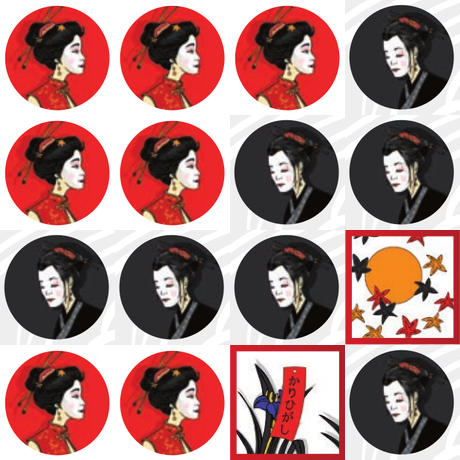

In [104]:
#turn_comb, turn_mask = unzip(win_combinations_of_turn[100]) # get a 100-th combination, for example

i_bin = bin_interpretation(win_combinations[turn_comb], lead_zero_count=16)
#i_bin = bin_interpretation(out_combinations[turn_comb], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias

# apply init tiles mask
tiles = list(np.reshape(tiles,16))
pos = 0
for i in bin_interpretation(turn_mask, lead_zero_count=16):
    if int(i):
        tiles[pos]=list(np.reshape(init_tiles,16))[pos]
    pos += 1
tiles = np.reshape(tiles,[4,4])

# draw
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")